# Import Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import numpy as np

# Create a Half Court Graph
def draw_half_court(ax=None, line_color="black", lw=2):
    """
    Draw an NBA half court with the hoop at (0, 0).
    Court coordinates: x from -25 to 25, y from 0 to ~47.
    """
    if ax is None:
        ax = plt.gca()

    # -------------------------
    # Court Components
    # -------------------------

    # Hoop
    hoop = Circle((0, 0), radius=0.75, linewidth=lw, color=line_color, fill=False)

    # Backboard
    backboard = Rectangle((-3, -0.75), 6, 0.15, linewidth=lw, color=line_color, fill=False)

    # Paint (key)
    paint_outer = Rectangle((-8, 0), 16, 19, linewidth=lw, color=line_color, fill=False)
    paint_inner = Rectangle((-6, 0), 12, 19, linewidth=lw, color=line_color, fill=False)

    # Free throw circle (top only)
    ft_circle_top = Arc((0, 19), 12, 12, theta1=0, theta2=180,
                        linewidth=lw, color=line_color)

    # Restricted area semicircle
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180,
                     linewidth=lw, color=line_color)

    # Corner 3 lines
    corner_three_left  = Rectangle((-22, 0), 0, 14, linewidth=lw, color=line_color)
    corner_three_right = Rectangle((22, 0), 0, 14, linewidth=lw, color=line_color)

    # -------------------------
    # Updated 3-point arc:
    # SHIFTED UP so it intersects reliably with the top of corner-3 lines
    # -------------------------
    three_arc = Arc((0, 5),    # moved arc CENTER up from (0,0) → (0,5)
                    47.5, 47.5,
                    theta1=22, theta2=158,
                    linewidth=lw, color=line_color)

    # Outer half court boundary
    outer = Rectangle((-25, 0), 50, 47,
                      linewidth=lw, color=line_color, fill=False)

    # Add everything
    for item in [
        hoop, backboard, paint_outer, paint_inner,
        ft_circle_top, restricted,
        corner_three_left, corner_three_right,
        three_arc, outer
    ]:
        ax.add_patch(item)

    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 47)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax


# -----------------------------------------------------------
# UPDATED SHOT PROFILE PLOT
#   - adds BOTH corner-3 zones (left & right)
#   - labels cleaned up
#   - keeps your structure intact
# -----------------------------------------------------------
def plot_zone_shot_profile_court(team_name,
                                 profile_label,
                                 rim_fg,
                                 short_mid_fg,
                                 long_mid_fg,
                                 corner3_fg,
                                 arc3_fg,
                                 cmap=plt.cm.RdYlBu_r,
                                 vmin=0.30,
                                 vmax=0.65):

    fig, ax = plt.subplots(figsize=(6, 8))
    draw_half_court(ax)

    # Normalize FG% for colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # -------------------------
    # Updated zone definitions
    # -------------------------
    zones = [
        ("At Rim",        0,   4,  rim_fg),

        ("Short Mid",     0,  15, short_mid_fg),
        ("Long Mid",      0,  23, long_mid_fg),

        # BOTH corner 3s now included
        ("Corner 3 (L)", -22,  5, corner3_fg),
        ("Corner 3 (R)",  22,  5, corner3_fg),

        ("Arc 3",         0,  32, arc3_fg),
    ]

    # -------------------------
    # Draw each shot zone bubble
    # -------------------------
    for label, x, y, fg in zones:

        # Handle NaN / missing
        if fg is None or np.isnan(fg):
            color = "gray"
            pct_label = "N/A"
        else:
            color = cmap(norm(fg))
            pct_label = f"{fg*100:.1f}%"

        # Draw circle
        ax.scatter(
            x, y,
            s=1500,                # circle size
            c=[fg],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=1.1,
            zorder=3,
        )

        # Percent text
        ax.text(
            x, y,
            pct_label,
            ha="center", va="center",
            fontsize=12, weight="bold", color="black",
            zorder=4
        )

        # Zone labels
        # Corner labels go BELOW bubble, others above
        if "Corner" in label:
            ax.text(
                x, y - 3,
                "Corner 3",
                ha="center", va="top",
                fontsize=9,
                zorder=4,
            )
        else:
            ax.text(
                x, y + 3.5,
                label,
                ha="center", va="bottom",
                fontsize=9,
                zorder=4
            )

    # -------------------------
    # Title and colorbar
    # -------------------------
    ax.set_title(
        f"{team_name} Shot Profile – Accuracy\n({profile_label})",
        fontsize=14, fontweight="bold", pad=10
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Field Goal %", fontsize=10)

    plt.tight_layout()
    plt.show()

# --- Helper: compute zone FG% for a given DataFrame + filter ---

def compute_zone_fg(df, game_type=None):
    """
    Given a shot distribution DataFrame, aggregate FGM/FGA by zone
    and return a dict of zone FG% as decimals.

    Assumes columns:
        AtRimFGM, AtRimFGA,
        ShortMidRangeFGM, ShortMidRangeFGA,
        LongMidRangeFGM, LongMidRangeFGA,
        Corner3FGM, Corner3FGA,
        Arc3FGM, Arc3FGA
    """
    if game_type is not None:
        df = df[df["Game Type"] == game_type]

    # avoid division by zero with .sum()
    def safe_fg(makes, attempts):
        makes_sum = df[makes].sum()
        att_sum   = df[attempts].sum()
        return np.nan if att_sum == 0 else makes_sum / att_sum

    return {
        "rim_fg":       safe_fg("AtRimFGM",         "AtRimFGA"),
        "short_mid_fg": safe_fg("ShortMidRangeFGM","ShortMidRangeFGA"),
        "long_mid_fg":  safe_fg("LongMidRangeFGM", "LongMidRangeFGA"),
        "corner3_fg":   safe_fg("Corner3FGM",       "Corner3FGA"),
        "arc3_fg":      safe_fg("Arc3FGM",          "Arc3FGA"),
    }

# ---------------------------------------------------------
# 1) DETROIT PISTONS – Regular Season (pre-Game 5)
# ---------------------------------------------------------
pistons_reg = pistons_shots[pistons_shots["Game Type"] == "Regular Season"]
pistons_reg_fg = compute_zone_fg(pistons_reg)

plot_zone_shot_profile_court(
    team_name="Detroit Pistons",
    profile_label="Regular Season (Pre-G5)",
    rim_fg=pistons_reg_fg["rim_fg"],
    short_mid_fg=pistons_reg_fg["short_mid_fg"],
    long_mid_fg=pistons_reg_fg["long_mid_fg"],
    corner3_fg=pistons_reg_fg["corner3_fg"],
    arc3_fg=pistons_reg_fg["arc3_fg"],
)

# ---------------------------------------------------------
# 2) DETROIT PISTONS – Playoffs (pre-Game 5)
# ---------------------------------------------------------
pistons_playoffs = pistons_shots[pistons_shots["Game Type"] == "Playoffs"]
pistons_po_fg = compute_zone_fg(pistons_playoffs)

plot_zone_shot_profile_court(
    team_name="Detroit Pistons",
    profile_label="Playoffs (Pre-G5)",
    rim_fg=pistons_po_fg["rim_fg"],
    short_mid_fg=pistons_po_fg["short_mid_fg"],
    long_mid_fg=pistons_po_fg["long_mid_fg"],
    corner3_fg=pistons_po_fg["corner3_fg"],
    arc3_fg=pistons_po_fg["arc3_fg"],
)

# ---------------------------------------------------------
# 3) NEW YORK KNICKS – Playoffs (pre-Game 5)
#    (This doubles as “Pistons defense vs Knicks offense”)
# ---------------------------------------------------------
knicks_playoffs = knicks_shots[knicks_shots["Game Type"] == "Playoffs"]
knicks_po_fg = compute_zone_fg(knicks_playoffs)

plot_zone_shot_profile_court(
    team_name="New York Knicks",
    profile_label="Playoffs (Pre-G5)",
    rim_fg=knicks_po_fg["rim_fg"],
    short_mid_fg=knicks_po_fg["short_mid_fg"],
    long_mid_fg=knicks_po_fg["long_mid_fg"],
    corner3_fg=knicks_po_fg["corner3_fg"],
    arc3_fg=knicks_po_fg["arc3_fg"],
)


In [3]:
!pip install nba_api


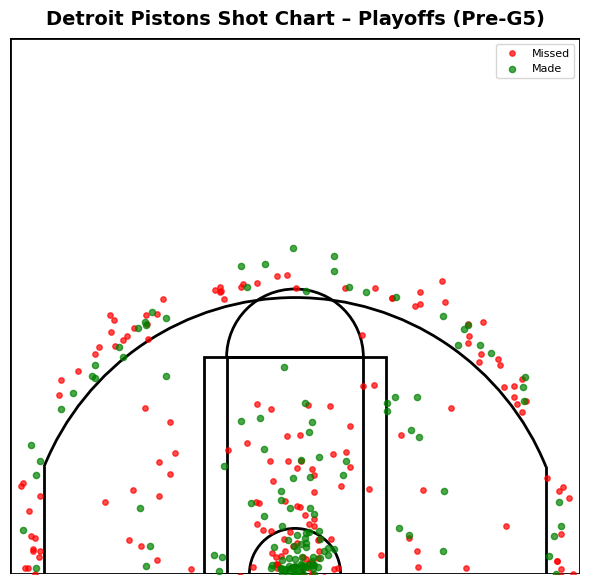

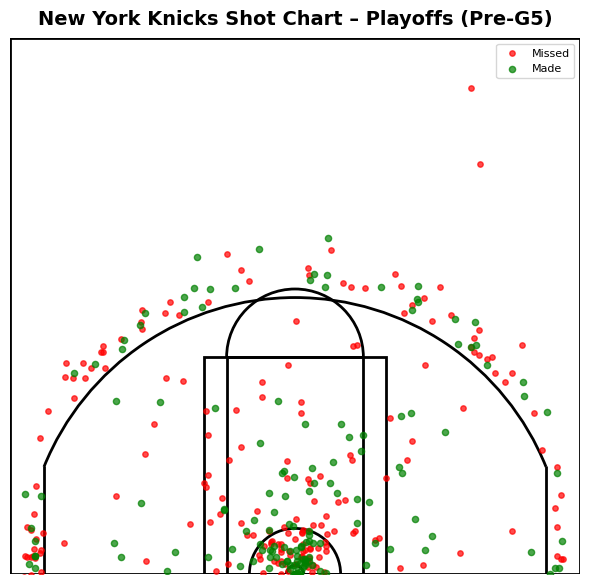

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Rectangle, Arc
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import teams

# ---------------------------
# 1. Court drawing helper
# ---------------------------
from matplotlib.patches import Circle, Rectangle, Arc

def draw_nba_half_court(ax=None, line_color="black", lw=2):
    """
    Standard NBA half court (compatible with nba_api LOC_X / LOC_Y).
    Hoop at (0, 0); x ∈ [-250, 250], y ∈ [0, 470].
    """
    if ax is None:
        ax = plt.gca()

    # Hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=line_color, fill=False)

    # Backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=line_color)

    # Paint
    outer_box = Rectangle((-80, 0), 160, 190, linewidth=lw, color=line_color, fill=False)
    inner_box = Rectangle((-60, 0), 120, 190, linewidth=lw, color=line_color, fill=False)

    # Free throw circle (top)
    ft_circle_top = Arc((0, 190), 120, 120, theta1=0, theta2=180,
                        linewidth=lw, color=line_color)

    # Restricted area
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180,
                     linewidth=lw, color=line_color)

    # Corner threes
    # Make these end roughly where the 3pt arc crosses x=±220 (y≈95)
    corner_height = 95  # tweak if you want it a bit higher/lower
    corner_three_left  = Rectangle((-220, 0), 0, corner_height, linewidth=lw, color=line_color)
    corner_three_right = Rectangle(( 220, 0), 0, corner_height, linewidth=lw, color=line_color)

    # 3pt arc (center slightly above hoop, radius ≈237.5)
    three_arc = Arc((0, 5), 475, 475, theta1=22, theta2=158,
                    linewidth=lw, color=line_color)

    # Half-court boundary
    outer_lines = Rectangle((-250, 0), 500, 470, linewidth=lw, color=line_color, fill=False)

    for obj in [
        hoop, backboard, outer_box, inner_box,
        ft_circle_top, restricted,
        corner_three_left, corner_three_right,
        three_arc, outer_lines
    ]:
        ax.add_patch(obj)

    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    ax.set_aspect("equal")
    ax.axis("off")
    return ax



# ---------------------------
# 2. Helper: get team ID by name
# ---------------------------
def get_team_id(team_name: str) -> int:
    """
    Look up NBA team ID using nba_api.stats.static.teams.
    Example: "New York Knicks" or "Detroit Pistons".
    """
    all_teams = teams.get_teams()
    for t in all_teams:
        if t["full_name"].lower() == team_name.lower():
            return t["id"]
    raise ValueError(f"Team '{team_name}' not found in NBA teams list.")


# ---------------------------
# 3. Pull shot data via nba_api
# ---------------------------
def get_team_shots(team_name: str,
                   season: str = "2024-25",
                   season_type: str = "Playoffs",
                   date_to: str | None = None) -> pd.DataFrame:
    """
    Get all shots for a team from nba_api shotchartdetail.

    Parameters:
        team_name  : "Detroit Pistons", "New York Knicks", etc.
        season     : "2024-25", "2023-24", etc.
        season_type: "Regular Season" or "Playoffs"
        date_to    : optional 'YYYY-MM-DD' to limit games up to that date
                     (e.g., '2025-04-28' for 'pre-Game 5')

    Returns: pandas DataFrame of shots with LOC_X, LOC_Y, SHOT_MADE_FLAG, SHOT_ZONE_BASIC, etc.
    """
    team_id = get_team_id(team_name)

    # Build filters
    if date_to is None:
        date_to_param = None
    else:
        date_to_param = date_to

    # Call NBA Stats API
    sc = shotchartdetail.ShotChartDetail(
        team_id=team_id,
        player_id=0,                # 0 = all players on team
        season_type_all_star=season_type,
        season_nullable=season,
        context_measure_simple="FGA",
        date_to_nullable=date_to_param,
        date_from_nullable=None,
    )

    shots = sc.get_data_frames()[0]   # first DataFrame is the shot chart

    # Keep only useful columns
    keep_cols = [
        "GAME_DATE", "GAME_ID", "SHOT_MADE_FLAG",
        "LOC_X", "LOC_Y",
        "SHOT_TYPE", "SHOT_ZONE_BASIC", "SHOT_ZONE_AREA", "SHOT_DISTANCE"
    ]
    shots = shots[keep_cols].copy()
    shots["GAME_DATE"] = pd.to_datetime(shots["GAME_DATE"])
    return shots


# ---------------------------
# 4. Plot shot chart for a team
# ---------------------------
def plot_team_shot_chart(shots_df: pd.DataFrame,
                         team_name: str,
                         title_suffix: str = "",
                         makes_color="green",
                         misses_color="red",
                         alpha=0.7):
    """
    Plot all shots as scatter points on a half court.
    Uses LOC_X / LOC_Y from nba_api shot data.
    """
    fig, ax = plt.subplots(figsize=(6, 8))
    draw_nba_half_court(ax)

    # Split makes / misses
    made = shots_df[shots_df["SHOT_MADE_FLAG"] == 1]
    missed = shots_df[shots_df["SHOT_MADE_FLAG"] == 0]

    ax.scatter(
        missed["LOC_X"], missed["LOC_Y"],
        c=misses_color, s=15, alpha=alpha, label="Missed"
    )
    ax.scatter(
        made["LOC_X"], made["LOC_Y"],
        c=makes_color, s=20, alpha=alpha, label="Made"
    )

    ax.legend(loc="upper right", fontsize=8)
    ax.set_title(f"{team_name} Shot Chart {title_suffix}", fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()
    plt.show()


# =====================================================
# EXAMPLE USAGE
# =====================================================

# 1) Pistons Playoffs, pre-Game 5 (cutoff date is up to you)
pistons_shots_api = get_team_shots(
    team_name="Detroit Pistons",
    season="2024-25",
    season_type="Playoffs",
    date_to="2025-04-28"   # pretend G5 is 2025-04-29
)

plot_team_shot_chart(
    pistons_shots_api,
    team_name="Detroit Pistons",
    title_suffix="– Playoffs (Pre-G5)"
)

# 2) Knicks Playoffs, pre-Game 5 (for defensive view)
knicks_shots_api = get_team_shots(
    team_name="New York Knicks",
    season="2024-25",
    season_type="Playoffs",
    date_to="2025-04-28"
)

plot_team_shot_chart(
    knicks_shots_api,
    team_name="New York Knicks",
    title_suffix="– Playoffs (Pre-G5)"
)


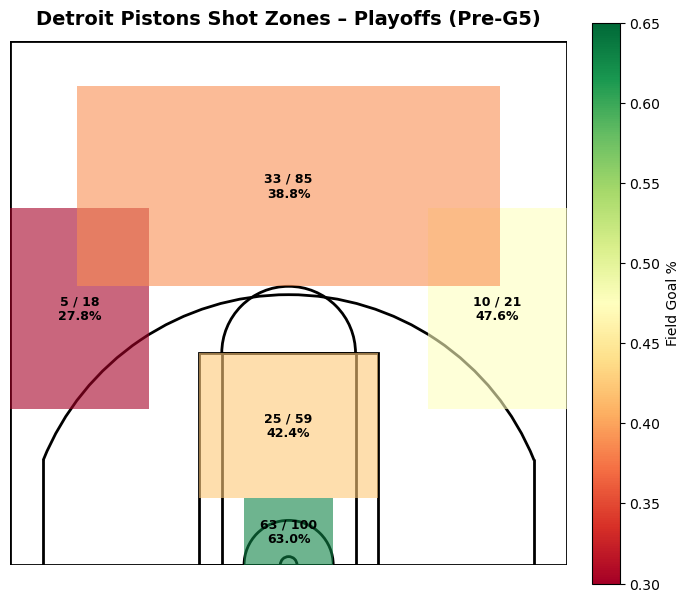

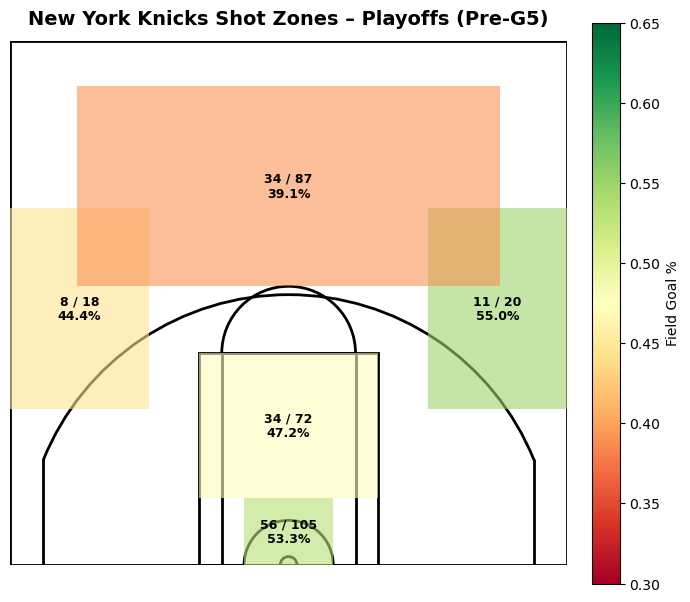

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

def compute_simple_zones(shots_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute makes / attempts / FG% for a small set of intuitive zones.
    Uses SHOT_ZONE_BASIC and SHOT_ZONE_AREA from nba_api shot data.
    """
    z_basic = shots_df["SHOT_ZONE_BASIC"]
    z_area  = shots_df["SHOT_ZONE_AREA"]
    made    = shots_df["SHOT_MADE_FLAG"]

    zones = {}

    def add_zone(label, mask):
        attempts = mask.sum()
        makes = made[mask].sum()
        fg = makes / attempts if attempts > 0 else np.nan
        zones[label] = {"FGA": attempts, "FGM": makes, "FG%": fg}

    # Restricted area
    add_zone(
        "Restricted Area",
        (z_basic == "Restricted Area")
    )

    # Paint (non-RA)
    add_zone(
        "In Paint (Non-RA)",
        (z_basic == "In The Paint (Non-RA)")
    )

    # Midrange left / right
    add_zone(
        "Midrange Left",
        (z_basic == "Mid-Range") &
        z_area.isin(["Left Side(L)", "Left Side Center(LC)"])
    )
    add_zone(
        "Midrange Right",
        (z_basic == "Mid-Range") &
        z_area.isin(["Right Side(R)", "Right Side Center(RC)"])
    )

    # Corner 3s
    add_zone(
        "Left Corner 3",
        (z_basic == "Corner 3") & z_area.str.startswith("Left")
    )
    add_zone(
        "Right Corner 3",
        (z_basic == "Corner 3") & z_area.str.startswith("Right")
    )

    # Above-the-break 3s
    add_zone(
        "Above Break 3",
        (z_basic == "Above the Break 3")
    )

    zone_df = (pd.DataFrame(zones)
                 .T
                 .reset_index()
                 .rename(columns={"index": "Zone"}))

    return zone_df


def plot_zone_heatmap(shots_df: pd.DataFrame,
                      team_name: str,
                      title_suffix: str = "",
                      vmin=0.30,
                      vmax=0.65,
                      cmap=plt.cm.RdYlGn):
    """
    NBA.com-style zone chart: patches colored by FG%, with FGM/FGA/% labels.
    """
    zone_stats = compute_simple_zones(shots_df)

    fig, ax = plt.subplots(figsize=(7, 7))
    draw_nba_half_court(ax)

    # Normalize for colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Approximate court coordinates (in nba_api units, x[-250,250], y[0,470])
    # These don't have to be perfect – just reasonably placed.
    zone_patches = {
        "Restricted Area":  Rectangle((-40, 0), 80, 60),
        "In Paint (Non-RA)": Rectangle((-80, 60), 160, 130),

        "Midrange Left":  Rectangle((-250, 140), 125, 180),
        "Midrange Right": Rectangle((125, 140), 125, 180),

        "Left Corner 3":   Rectangle((-250, 0), 60, 140),
        "Right Corner 3":  Rectangle((190, 0), 60, 140),

        "Above Break 3":   Rectangle((-190, 250), 380, 180),
    }

    for _, row in zone_stats.iterrows():
        zone = row["Zone"]
        fgm  = row["FGM"]
        fga  = row["FGA"]
        fg   = row["FG%"]

        # Skip zones with 0 attempts so they don't clutter
        if fga == 0:
            continue

        patch = zone_patches.get(zone)
        if patch is None:
            continue

        # Color by FG%
        color = "gray" if np.isnan(fg) else cmap(norm(fg))
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
        patch.set_edgecolor("none")
        ax.add_patch(patch)

        # Label in the center of the patch
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + patch.get_height() / 2

        ax.text(
            x, y,
            f"{int(fgm)} / {int(fga)}\n{fg*100:0.1f}%",
            ha="center", va="center",
            fontsize=9, fontweight="bold", color="black"
        )

    ax.set_title(
        f"{team_name} Shot Zones {title_suffix}",
        fontsize=14, fontweight="bold", pad=12
    )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Field Goal %", fontsize=10)

    plt.tight_layout()
    plt.show()

# Pistons – Playoffs pre-G5
plot_zone_heatmap(
    pistons_shots_api,
    team_name="Detroit Pistons",
    title_suffix="– Playoffs (Pre-G5)"
)

# Knicks – Playoffs pre-G5
plot_zone_heatmap(
    knicks_shots_api,
    team_name="New York Knicks",
    title_suffix="– Playoffs (Pre-G5)"
)
